# World Happiness Report

## Introducción

El **World Happiness Report** es una iniciativa internacional que evalúa y clasifica a los países del mundo según los niveles de felicidad percibida por sus ciudadanos. Este conjunto de datos proviene de encuestas realizadas anualmente por Gallup World Poll y es utilizado ampliamente en investigaciones sobre bienestar, desarrollo social, economía conductual y políticas públicas.

Cada fila representa un país en un año determinado, e incluye una puntuación de felicidad junto con múltiples indicadores que ayudan a explicar esa puntuación.

In [1]:
import pandas as pd
data = pd.read_csv("/content/2015.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1

Hay 11 variables, ninguna tiene valores nulos. En este estudio nos interesa particularmente el *Happiness Score*, la puntuación de la felicidad, que es un número flotante. La puntuación de la felicidad es la suma de las seis columnas *Economy (GDP per Capita)*, *Family*, *Health (Life Expectancy)*, *Freedom*, *Trust (Government Corruption)*, *Generosity*, que describen el grado en que esos factores contribuyen a la evaluación de la felicidad en cada país.

El objetivo de este estudio es averiguar si hay diferencias de los puntajes de la felicidad entre las diferentes regiones del mundo, aplicando métodos paramétricos y no paramétricos según se requiera.

In [ ]:
#data.head()

## Comparación de medias de "Europa Central y Oriental" y "América Latina y el Caribe"

### Selección de los datos

In [ ]:
cae_europe = data[data["Region"] == "Central and Eastern Europe"]["Happiness Score"]
latin_america = data[data["Region"] == "Latin America and Caribbean"]["Happiness Score"]

In [ ]:
print("Número de datos de Europa Central y Oriental: ", len(cae_europe))
print("Número de datos de América Latina y el Caribe:  ", len(latin_america))

Número de datos de Europa Central y Oriental:  29
Número de datos de América Latina y el Caribe:   22


### Verificación de supuestos para prueba paramétrica

In [ ]:
from scipy.stats import shapiro, levene

stat1_sw, p1_sw = shapiro(cae_europe)
stat2_sw, p2_sw = shapiro(latin_america)
print("Pruebas de normalidad:")
print("p-valor (Central and Eastern Europe):", round(p1_sw, 3))
print("p-valor (Latin America and Caribbean):", round(p2_sw,3))

stat1_le, p1_le = levene(cae_europe, latin_america)
print("\n\nPrueba de homogeneidad de varianzas:")
print("p-valor:", round(p1_le,3))

Pruebas de normalidad:
p-valor (Central and Eastern Europe): 0.403
p-valor (Latin America and Caribbean): 0.186


Prueba de homogeneidad de varianzas:
p-valor: 0.494




*   Los p-valores de la pruebas de Shapiro-Wilk indican que las muestras provienen de poblaciones con distribuciones normales.
*   El p-valor de la prueba de Levene indica que hay homogeneidad de varianzas entre los dos grupos.



### Prueba t-Student para muestras independientes con varianzas iguales

$H_0$: Las medias de los dos grupos son iguales.

$H_{a}$: Las medias de los dos grupos son diferentes.

In [ ]:
from scipy.stats import ttest_ind
stat_ttest, p_ttest = ttest_ind(cae_europe, latin_america, equal_var = True)
print("Prueba de diferencia entre grupos:")
print("p-valor:", round(p_ttest, 5))

Prueba de diferencia entre grupos:
p-valor: 5e-05


El p-valor es menor que 0.05. Por lo tanto, se rechaza $H_{0}$ en favor de $H_{a}$ y se concluye las medias del puntaje de felicidad de las dos regiones son diferentes, con nivel de significancia $\alpha = 0.05$.

## Comparación de medias usando todas las muestras

### Verificación de supuestos para prueba paramétrica

In [ ]:
regions = ["Sub-Saharan Africa", "Central and Eastern Europe", "Latin America and Caribbean	", "Western Europe", "Middle East and Northern Africa",
           "Southeastern Asia", "Southern Asia", "Eastern Asia", "North America", "Australia and New Zealand"]

from scipy.stats import shapiro, levene
for region in regions:
  data_region = data[data["Region"] == region]["Happiness Score"]
  stat_reg, p_reg = shapiro(data_region)
  print("p-valor (", region, "): ", round(p_reg, 4))

p-valor ( Sub-Saharan Africa ):  0.8144
p-valor ( Central and Eastern Europe ):  0.403
p-valor ( Latin America and Caribbean	 ):  nan
p-valor ( Western Europe ):  0.0282
p-valor ( Middle East and Northern Africa ):  0.7837
p-valor ( Southeastern Asia ):  0.9575
p-valor ( Southern Asia ):  0.5863
p-valor ( Eastern Asia ):  0.6242
p-valor ( North America ):  nan
p-valor ( Australia and New Zealand ):  nan


<ipython-input-17-5954fece55ae>:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_reg, p_reg = shapiro(data_region)


Una muestra no cumple con el supuesto de distribución normal. Además, hay tres casos donde se reporta "nan"; esto se debe a que, como se muestra a continuación, hay muestras con tamaños muy pequeños.

In [ ]:
data["Region"].value_counts()

,count
Region,
Sub-Saharan Africa,40
Central and Eastern Europe,29
Latin America and Caribbean,22
Western Europe,21
Middle East and Northern Africa,20
Southeastern Asia,9
Southern Asia,7
Eastern Asia,6
North America,2


Adicionalmente, el ANOVA es sensible al desequilibrio de tamaños de muestra, especialmente si las varianzas no son iguales. En este caso, hacer una prueba de Levene no es adecuado porque hay muestras demasiado pequeños.

Por lo tanto, se concluye que no se cumplen los supuestos del método de la prueba F para comparar medias de grupos independientes. Por lo tanto, se implementará un método no paramétrico.

### Comparación de la mediana de los grupos usando Kruskall-Wallis

$H_{0}:$ Las medianas poblacionales son iguales (o todas las poblaciones tienen la misma distribución).

$H_{a}:$ Al menos una población difiere en su mediana (o al menos una población difiere en su distribución).

In [ ]:
from scipy.stats import kruskal

grupos = [
    data.loc[data["Region"] == region, "Happiness Score"].dropna()
    for region in regions
]

est_krus, p_krus = kruskal(*grupos)
print("Prueba de Kruskall-Wallis")
print("p-valor: ", round(p_krus, 3))

Prueba de Kruskall-Wallis
p-valor:  nan


<ipython-input-19-61590ef6c63c>:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  est_krus, p_krus = kruskal(*grupos)


El p-valor devuelto es nan.

In [ ]:
#help(kruskal)

En la documentación de la función *krusal* se dice que dado que se asume que el estadístico de prueba H sigue una distribución chi cuadrada, el tamaño de muestra en cada grupo no debe ser muy pequeño; así que una regla común es tener al menos 5 observaciones por grupo. Por lo tanto, será necesario eliminar a las regiones de Norte-América y Australia y Nueva Zelanda.

In [ ]:
grupos_filt = [g for g in grupos if g.dropna().size >= 2]

est_krus, p_krus = kruskal(*grupos_filt)
print("Prueba de Kruskall-Wallis")
print("p-valor: ", p_krus)

Prueba de Kruskall-Wallis
p-valor:  5.48104514696369e-14


Dado que el p-valor es cercano a 0, se rechaza $H_{0}$ en función de $H_{a}$. Por lo tanto, se concluye que al menos una región tiene una mediana (y, por lo tanto, una distribución) del puntaje de felicidad diferente que el resto, con nivel de significancia $\alpha = 0.05$.

### Prueba de Dunn para investigar qué regiones difieren

In [3]:
pip install scikit-posthocs

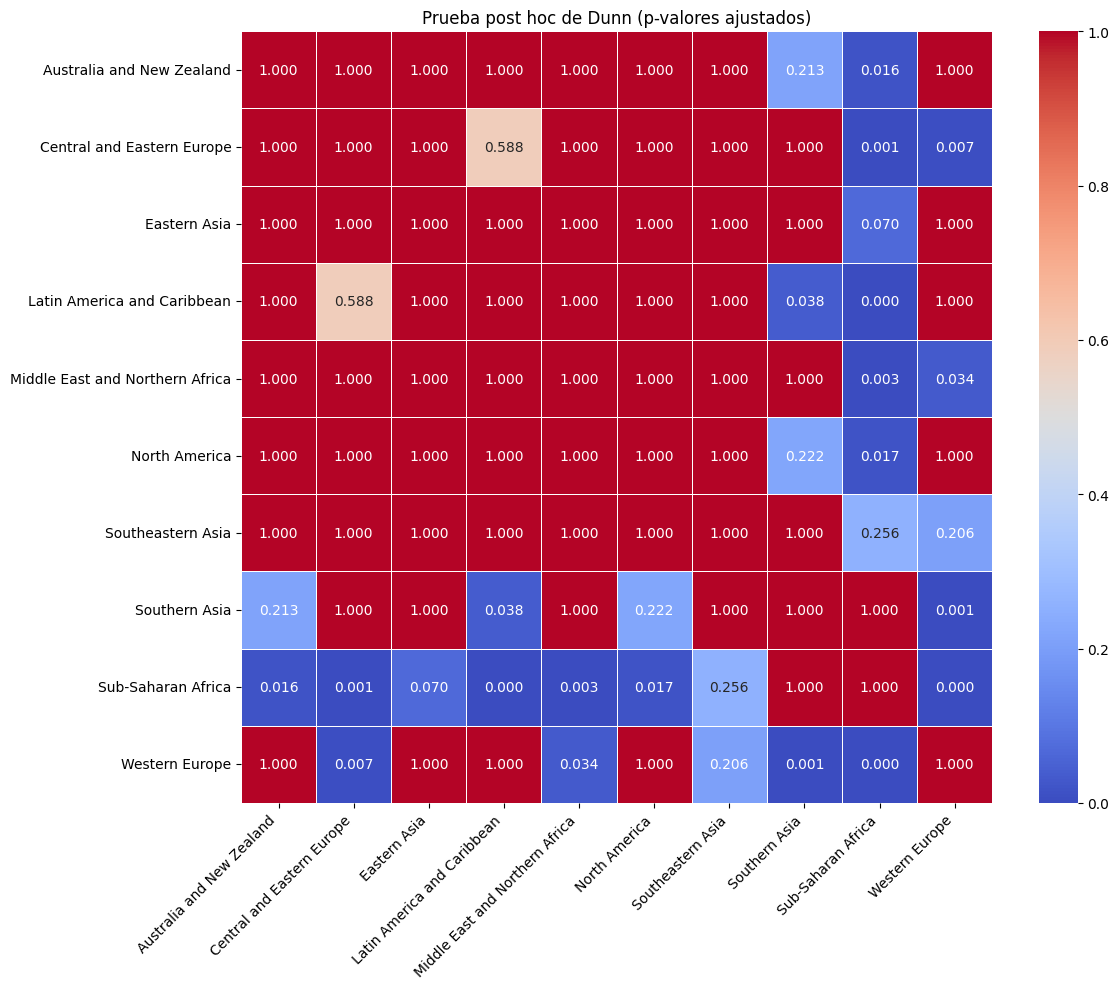

In [9]:
import scikit_posthocs as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dunn_result = sp.posthoc_dunn(data, val_col='Happiness Score', group_col='Region', p_adjust='bonferroni')

plt.figure(figsize=(12, 10))
sns.heatmap(dunn_result, annot=True, fmt=".3f", cmap="coolwarm", linewidths=.5)
plt.title("Prueba post hoc de Dunn (p-valores ajustados)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

* Los p-valores mostrados en las celdas de la matriz anterior muestran que las mayores diferencias se encuentran entre la región del África Subsahariana con el resto de regiones del mundo; la distribución de los puntajes de felicidad del África Subsahariana tiene diferencias significativas con el resto de regiones del mundo, salvo con el Sudeste y el Sur de Asia.
* Las regiones del Sur de Asia y Europa Occidental también presentan diferencias significativas con varias regiones del mundo.
* No hay diferencia significativa entre las medianas de Norte América y las distintas regiones de Europa, pero las regiones de Europa sí difieren entre sí.